In [711]:
from reliability.Distributions import Weibull_Distribution
from reliability.Fitters import Fit_Weibull_2P
from reliability.Probability_plotting import plot_points, plotting_positions, Weibull_probability_plot
from reliability.Utils import axes_transforms, probability_plot_xylims, probability_plot_xyticks, linear_regression
from reliability.Distributions import Weibull_Distribution

import matplotlib.pyplot as plt
import matplotlib as mpl

from cycler import cycler
from matplotlib import colors, colormaps
import matplotlib.ticker as mticker
import pandas as pd
from matplotlib.figure import figaspect
import seaborn as sns
import numpy as np
from scipy.special import gamma
from scipy.stats import weibull_min, linregress
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from scipy import interpolate
import itertools
import math
from shapely import Polygon
from shapely.plotting import plot_polygon

# Configuration

In [712]:
angle_method = True ## Calculate strength via fracture angle or simple diameter
design_prob = 1-0.05 ## Desired quantile of survival for design

In [713]:
stress_label = "Failure stress (MPa)"
v_label = "Volume ($mm^3$)"
sa_label = "Surface area ($mm^2$)"

In [714]:
plt.style.use('seaborn-v0_8-ticks')
mpl.rcParams["lines.linewidth"] = 1.5
mpl.rcParams["legend.frameon"] = True
mpl.rcParams["scatter.marker"] = "."

In [715]:
marker_cycler = itertools.cycle(("o", "^", "x", "+"))

# Load in and clean data

In [716]:
fibre_data = pd.read_csv("Fibre_Data_V1_avg.csv")

In [717]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(fibre_data):
    # Drop rows with missing data in column: 'fracture_stress'
    fibre_data = fibre_data.dropna(subset=['fracture_stress'])
    fibre_data = fibre_data.dropna(how="all", axis=1)
    return fibre_data

fibre_data_clean = clean_data(fibre_data.copy())

In [718]:
fibre_data_clean["series"] = fibre_data_clean["sample"].str[0] ## Extract series letter from the "sample" column

fibre_data_clean = fibre_data_clean.drop(fibre_data_clean[fibre_data_clean["series"] == "A"].index)

fibre_data_clean = fibre_data_clean.drop(fibre_data_clean[fibre_data_clean["series"] == "C"].index)

fibre_data_clean["gage_length"] = 25

In [719]:
fibre_data_clean

,sample,sample_long,average_fracture_diameter,fracture_diameter,...,fracture_stress,youngs_modulus,series,gage_length
0,F1,Favimat 1,0.0477,0.0455,...,240.8,22.2,F,25
1,F2,Favimat 2,0.0477,0.0454,...,252.7,21.1,F,25
2,F3,Favimat 3,0.0477,0.0454,...,206.2,20.4,F,25
3,F4,Favimat 4,0.0477,0.0365,...,135.7,17.1,F,25
4,F5,Favimat 5,0.0477,0.0486,...,187.6,20.7,F,25
5,F6,Favimat 6,0.0477,0.0486,...,185.8,20.6,F,25
6,F7,Favimat 7,0.0477,0.04,...,178.4,18.5,F,25
7,F8,Favimat 8,0.0477,0.0536,...,118,16.8,F,25
8,F9,Favimat 9,0.0477,0.0536,...,177.6,17.4,F,25
9,F11,Favimat 11,0.0477,0.0598,...,187.1,17.7,F,25


# Analyse Strength

## Functions

In [720]:
def fit_and_plot_weibull(data, design_failure):
    ### Big function to fit and plot the needed weibull distributions of each series. Saves a figure of individual and collated distributions

    ## Set up matplotlib figures and axes
    ind_fig, ind_ax = plt.subplots()
    collated_fig, collated_ax = plt.subplots()
    
    ## Create a separate dataframe with statistics considering the entire series
    data_anal = data[["series", "fracture_diameter", "fracture_stress"]].groupby("series").agg(['mean', "std"])
    data_anal.columns = data_anal.columns.map('_'.join)
    data_anal["fracture_stress_CV"] = data_anal["fracture_stress_std"] / data_anal["fracture_stress_mean"] * 100

    ## Sort the values to display nicer in figure legends
    data_anal = data_anal.sort_values("fracture_diameter_mean")

    fracture_prob = pd.DataFrame()

    unique_values = data_anal.index.unique()

    ## Fit a weibull distribution to each series, also keeping the plotting positions to be scaled later
    for letter in unique_values:
        fracture_frame = data.loc[data["series"] == letter, ["fracture_stress"]].copy()
        plot_data = fracture_frame.squeeze(axis=1).to_numpy(dtype="float32")

        # data_anal.loc[letter, "support_span"] = data.loc[data["series"] == letter, "support_span"].iloc[0]
        # data_anal.loc[letter, "load_span"] = data.loc[data["series"] == letter, "load_span"].iloc[0]

        ## Skip fitting if sample size is too small
        if len(plot_data) < 2: continue
        
        avg_diameter = data_anal.loc[letter, "fracture_diameter_mean"]
        legend_text = "%s series: ~%.2f mm dia." % (letter, avg_diameter)
        
        plt.sca(ind_ax)
        ## Fit the current data to a weibull (Also makes a figure)
        fracture_fit = Fit_Weibull_2P(failures=plot_data, print_results=False, label=legend_text, method="LS", CI_type="none")
        
        ## Individual figure formatting
        ind_ax.get_lines()[0].set_color("red")
        ind_ax.get_lines()[0].set_linestyle("dashed")
        ind_fig.set_size_inches(7, 8)
        plt.ylabel("Probability of failure")
        plt.xlabel(stress_label)
        plt.title("")
        plt.legend(loc="upper left")

        ## Save and clear fig
        ind_fig.savefig("Figs_fibre/series_" + letter, bbox_inches = "tight")
        ind_ax.cla()

        ## Also grab the plotting positions from the reliability library
        fail_x, fail_y = plotting_positions(plot_data)
        fracture_frame.loc[:, "Fail Check"] = fail_x ## This should be the same as "fracture_stress"
        fracture_frame.loc[:, "Fail Prob"] = fail_y

        fracture_frame["char_strength"] = fracture_fit.alpha
        fracture_frame["weibull_modulus"] = fracture_fit.beta

        fracture_frame = fracture_frame.drop(["fracture_stress"], axis=1)
        fracture_prob =  pd.concat([fracture_prob, fracture_frame], axis=0)

        data_anal.loc[letter, "valid_samples"] = len(plot_data)
        data_anal.loc[letter, "char_strength"] = fracture_fit.alpha
        data_anal.loc[letter, "char_strength_95%_upper"] = fracture_fit.alpha_upper
        data_anal.loc[letter, "char_strength_95%_lower"] = fracture_fit.alpha_lower
        data_anal.loc[letter, "weibull_modulus"] = fracture_fit.beta
        data_anal.loc[letter, "weibull_modulus_95%_upper"] = fracture_fit.beta_upper
        data_anal.loc[letter, "weibull_modulus_95%_lower"] = fracture_fit.beta_lower
        data_anal.loc[letter, "Design Strength"] = fracture_fit.distribution.inverse_SF(design_failure)

        collated_legend_text = "%s, dia.= ~%.2f mm" % (letter, avg_diameter)

        ## Add a line to the collated figure
        plt.sca(collated_ax)
        Weibull_probability_plot(failures=plot_data, __fitted_dist_params=fracture_fit.distribution, show_scatter_points=False, CI_type=None, label=collated_legend_text)

    ind_fig.clf()

    ## Collated figure formatting and save
    collated_ax.set_title("")
    collated_ax.set_ylabel("Probability of failure")
    collated_ax.set_xlabel(stress_label)

    collated_fig.set_size_inches(7, 8)

    collated_ax.set_xlim([10, 300])
    collated_ax.set_ylim([0.1, 0.9])

    collated_fig.savefig("Figs_fibre/collated", bbox_inches = "tight")

    ## Save relevant data back to the original dataframe
    data = pd.concat([data, fracture_prob], axis=1)

    return data, data_anal

## Run Analysis

<Figure size 700x800 with 0 Axes>

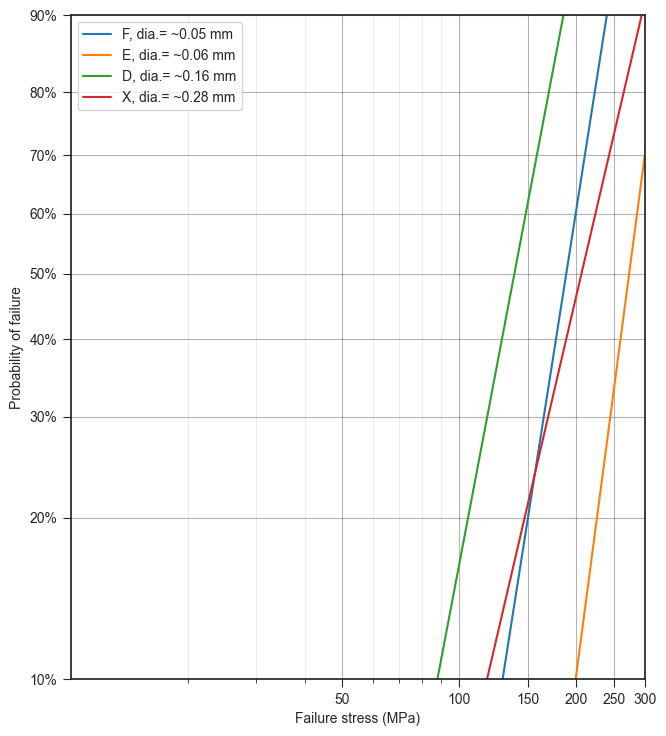

In [721]:
fibre_data_clean, fibre_data_anal = fit_and_plot_weibull(fibre_data_clean, design_prob)

In [722]:
fibre_data_anal

,fracture_diameter_mean,fracture_diameter_std,fracture_stress_mean,fracture_stress_std,...,weibull_modulus,weibull_modulus_95%_upper,weibull_modulus_95%_lower,Design Strength
series,,,,,,,,,
F,0.0477,0.00681339,186.99,41.01,...,4.99402,8.13428,3.06606,111.948
E,0.0641333,0.00681273,272.067,44.2735,...,5.9454,16.9939,2.08003,176.648
D,0.1599,0,137.789,33.1328,...,4.13075,7.3656,2.3166,73.8205
X,0.279254,0.0779915,206.4,62.8099,...,3.36623,5.2998,2.1381,95.2079


In [723]:
## Double check if appended plotting positions align with original fracture stress

check_alignment = fibre_data_clean[["fracture_stress", "Fail Check"]].dropna()

check_alignment = np.isclose(check_alignment["fracture_stress"], check_alignment["Fail Check"])
check_alignment

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

# Size effect normalisation

## Functions

In [724]:
## Simple sample surface area and volume
def cylinder_gage_SA(diameter: float, length: float) -> float: return np.pi * diameter * length
def cylinder_gage_V(diameter: float, length: float) -> float: return (np.pi * diameter**2 * length) / 4

In [725]:
def calc_sample_geometry(sample_data: pd.DataFrame, analysis_data: pd.DataFrame):
    ### Calculate the required geometry for each value in the dataframe

    ## Simple V and SA for individual samples
    sample_data["gage_V"] = sample_data.apply(lambda row: cylinder_gage_V(row["fracture_diameter"], row["gage_length"]), axis=1)
    sample_data["gage_SA"] = sample_data.apply(lambda row: cylinder_gage_SA(row["fracture_diameter"], row["gage_length"]), axis=1)

    ## Simple V and SA for series
    # analysis_data["mean_gage_V"] = analysis_data.apply(lambda row: cylinder_gage_V(row["fracture_diameter_mean"], row["gage_length"]), axis=1)
    # analysis_data["mean_gage_SA"] = analysis_data.apply(lambda row: cylinder_gage_SA(row["fracture_diameter_mean"], row["gage_length"]), axis=1)

    return sample_data, analysis_data

In [726]:
def size_effect_normalize(original_prob: float, original_size: float, standard_size: float) -> float:
    ### Normalising formula from sphere compression paper (among other places)
    size_ratio = standard_size / original_size
    return 1 - (1 - original_prob)**size_ratio

In [727]:
def normalize_data(data):
    ### Probability normalised to a standard size, 1
    data["Fail Prob V Adj"] = data.apply(lambda row: size_effect_normalize(row["Fail Prob"], row["gage_V"], 0.01), axis=1)
    data["Fail Prob SA Adj"] = data.apply(lambda row: size_effect_normalize(row["Fail Prob"], row["gage_SA"], 1), axis=1)

    return data

In [728]:
def fit_normalized_data(data, method):
    ### Use least squares regression to fit a line to the normalised values. Also do the transformations required for weibull parameters
    if method == "V":
        method_column = "Fail Prob V Adj"
    elif method == "SA":
        method_column = "Fail Prob SA Adj"
    else:
        raise("Please choose a valid method, volume (V) or surface area (SA)")
    
    least_squares_data = data[["fracture_stress", method_column]].dropna()

    stress = least_squares_data["fracture_stress"].to_numpy()
    fail_prob = least_squares_data[method_column].to_numpy()

    x = np.log(stress)
    y = np.log(-np.log(1-fail_prob))

    # m, c = linear_regression(x=x,y=y,RRX_or_RRY="RRX",show_plot=True,label='RRX')
    # m, c = linear_regression(x=x,y=y,RRX_or_RRY="RRY",show_plot=True,label='RRY')

    result = linregress(x, y)

    beta = result.slope
    alpha = np.exp(-result.intercept / beta)

    return (alpha, beta, result.rvalue)
    

In [729]:
def fit_normalized_data(data, method):
    ### Use least squares regression to fit a line to the normalised values. Also do the transformations required for weibull parameters
    if method == "V":
        method_column = "Fail Prob V Adj"
    elif method == "SA":
        method_column = "Fail Prob SA Adj"
    else:
        raise("Please choose a valid method, volume (V) or surface area (SA)")
    
    least_squares_data = data[["fracture_stress", method_column]].dropna()

    stress = least_squares_data["fracture_stress"].to_numpy()
    fail_prob = least_squares_data[method_column].to_numpy()

    x = np.log(stress)
    y = np.log(-np.log(1-fail_prob))

    # m, c = linear_regression(x=x,y=y,RRX_or_RRY="RRX",show_plot=True,label='RRX')
    # m, c = linear_regression(x=x,y=y,RRX_or_RRY="RRY",show_plot=True,label='RRY')

    result = linregress(x, y)

    beta = result.slope
    alpha = np.exp(-result.intercept / beta)

    return (alpha, beta, result.rvalue)
    

In [730]:
def plot_normalized_weibull(data, analysed_data):
    ### Make a big fancy figure of normalised data with colour coded sample series
    normalise_unique_series = analysed_data.dropna().index.unique()

    ##  Get parameters required to generate weibull distributions
    v_alpha, v_beta, v_r = fit_normalized_data(data, "V")
    sa_alpha, sa_beta, sa_r = fit_normalized_data(data, "SA")

    ## Make distributions according to parameters
    v_dist = Weibull_Distribution(alpha=v_alpha, beta=v_beta)
    sa_dist = Weibull_Distribution(alpha=sa_alpha, beta=sa_beta)
    
    ## Get values for plotting the distribution line
    v_dist_x = np.linspace(70, 300, 200)
    v_dist_y = v_dist.CDF(xvals=v_dist_x, show_plot=False)

    sa_dist_x = np.linspace(70, 300, 200)
    sa_dist_y = sa_dist.CDF(xvals=sa_dist_x, show_plot=False)

    ## Plot the distribution lines
    plt.clf()
    fig, (ax_v, ax_sa) = plt.subplots(1,2, layout="constrained")

    fit_label_fmt = "{}-scaled Weibull Distribution:\n $\\sigma_o = {:.2f}$, $m = {:.2f}$, $r^2 = {:.2f}$"

    ax_v.plot(v_dist_x, v_dist_y, "--r", label=fit_label_fmt.format("Volume", v_alpha, v_beta, v_r**2))
    ax_sa.plot(sa_dist_x, sa_dist_y, "--r", label=fit_label_fmt.format("Surface area", sa_alpha, sa_beta, sa_r**2))

    ## Put a scatter plot of each series on the figure, with nice colour and marker coding
    for i, letter in enumerate(normalise_unique_series):
        plot_data = data.loc[data["series"] == letter]

        marker_symb = next(marker_cycler)
        avg_diameter = analysed_data.loc[letter, "fracture_diameter_mean"]
        legend_text = "%s series: ~%.2f mm" % (letter, avg_diameter)

        ax_v.scatter(data=plot_data, x="fracture_stress", y="Fail Prob V Adj", label=legend_text, marker=marker_symb)
        ax_sa.scatter(data=plot_data, x="fracture_stress", y="Fail Prob SA Adj", label=legend_text, marker=marker_symb)

    ## Use some funky functions from the reliability library to scale the weibull distribution to a straight line
    ax_v.set_yscale('function', functions=(axes_transforms.weibull_forward, axes_transforms.weibull_inverse))
    ax_v.set_xscale("log")

    ax_sa.set_yscale('function', functions=(axes_transforms.weibull_forward, axes_transforms.weibull_inverse))
    ax_sa.set_xscale("log")

    ## Using reliability library functions to format the axes correctly
    plt.sca(ax_v)
    probability_plot_xyticks()
    probability_plot_xylims(v_dist_x, v_dist_y, "weibull")

    plt.sca(ax_sa)
    probability_plot_xyticks()
    probability_plot_xylims(sa_dist_x, sa_dist_y, "weibull")

    ## Labelling and formatting
    ax_v.set_xlabel(stress_label)
    ax_v.set_ylabel("Probability of failure")

    ax_sa.set_xlabel(stress_label)
    ax_sa.set_ylabel("Probability of failure")

    ax_v.grid(zorder=2)
    ax_v.set_axisbelow(True)
    ax_v.legend()

    ax_sa.grid(zorder=2)
    ax_sa.set_axisbelow(True)
    ax_sa.legend()

    plt.gcf().set_size_inches(12, 9)

    print("Volume rsquared = ", v_r**2)
    print("Surface area rsquared = ", sa_r**2)

    return v_dist, sa_dist

In [731]:
fibre_data_clean, fibre_data_anal = calc_sample_geometry(fibre_data_clean, fibre_data_anal)
fibre_data_clean = normalize_data(fibre_data_clean)

In [732]:
fibre_data_clean

,sample,sample_long,average_fracture_diameter,fracture_diameter,...,gage_V,gage_SA,Fail Prob V Adj,Fail Prob SA Adj
0,F1,Favimat 1,0.0477,0.0455,...,0.0406493,3.57356,0.359536,0.397596
1,F2,Favimat 2,0.0477,0.0454,...,0.0404708,3.56571,0.486637,0.530828
2,F3,Favimat 3,0.0477,0.0454,...,0.0404708,3.56571,0.283385,0.314907
3,F4,Favimat 4,0.0477,0.0365,...,0.0261587,2.8667,0.0659552,0.0603621
4,F5,Favimat 5,0.0477,0.0486,...,0.046377,3.81704,0.199759,0.237195
5,F6,Favimat 6,0.0477,0.0486,...,0.046377,3.81704,0.121609,0.145758
6,F7,Favimat 7,0.0477,0.04,...,0.0314159,3.14159,0.130607,0.130607
7,F8,Favimat 8,0.0477,0.0536,...,0.0564104,4.20973,0.0122763,0.0164159
8,F9,Favimat 9,0.0477,0.0536,...,0.0564104,4.20973,0.0518907,0.0689129
9,F11,Favimat 11,0.0477,0.0598,...,0.0702154,4.69668,0.106952,0.155582


Volume rsquared =  0.29236341743408967
Surface area rsquared =  0.47703153180231


<Figure size 640x480 with 0 Axes>

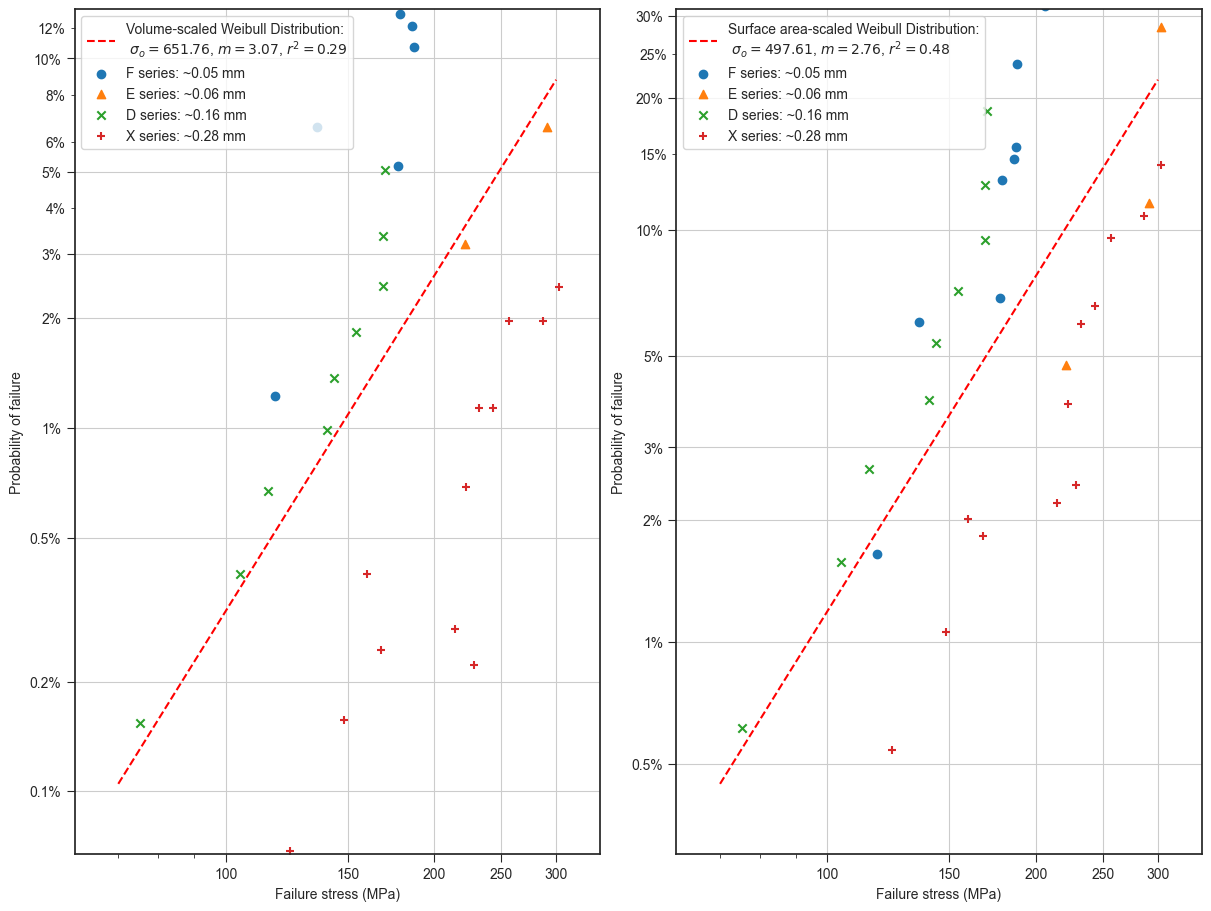

In [733]:
v_dist, sa_dist = plot_normalized_weibull(fibre_data_clean, fibre_data_anal)